In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.integrate import quad,dblquad,nquad

from sklearn import metrics

In [64]:
def ROC(label, predict, pos_label, method = 1):
        '''
        input: label, predict score, both in series or array
        output: ROC curve
        method = 1: one-by-one change to positive, from larger score to little
        method = 2: change threshold, suitable for large dataset
        only when the score order is true (i.e., label sorted as ---...---+++...+++ without chaos), AUC=1
        <=> there is a threshold under which the accuracy = 100%
        '''
        
        # 0-1 normalization; sorting by column predict
        frame = pd.DataFrame({'label':label, 'predict':predict})
        frame['predict'] = (frame['predict']-frame['predict'].min())/np.ptp(frame['predict'])
        frame = frame.sort_values(by='predict', ascending=False)
        frame.index = range(1,frame.shape[0]+1)
        
        # identify the positive & negative label
        # if not given, choose the majority of labels with 5 highest score as pos_label
        if pos_label == None:
            pos_label = list(Counter(frame[0].tail()).keys())[0]
        label_set = list(frame['label'].drop_duplicates())
        label_set.remove(pos_label)
        neg_label = label_set[0]

        P = Counter(frame['label'])[pos_label]
        N = Counter(frame['label'])[neg_label]
        
        frame['temp'] = neg_label
        TPRate = []
        FPRate = []                                           

        # method 1: one-by-one change to positive
        if method == 1:
            TPRate.append(0)
            FPRate.append(0)
            for i in range(label.size):
                frame.iloc[i,2] = pos_label
                try:                
                    if frame['predict'].iloc[i] == frame['predict'].iloc[i+1]:
                        continue
                except:
                    pass
                TPR = sum(frame[frame.iloc[:,0] == frame.iloc[:,2]].iloc[:,0] == pos_label)/P
                FPR = 1 - sum(frame[frame.iloc[:,0] == frame.iloc[:,2]].iloc[:,0] == neg_label)/N
                TPRate.append(TPR)
                FPRate.append(FPR)
                
        # method 2: change threshold in uniform
        elif method == 2:
            for thres in [x*0.01 for x in range(101)]:
                frame['temp'][frame['predict'] >= 1-thres] = pos_label
                TPR = sum(frame[frame.iloc[:,0] == frame.iloc[:,2]].iloc[:,0] == pos_label)/P
                FPR = 1 - sum(frame[frame.iloc[:,0] == frame.iloc[:,2]].iloc[:,0] == neg_label)/N
                TPRate.append(TPR) 
                FPRate.append(FPR)     
                
        # calculating AUC value
        FPRate.append(0)
        TPRate.append(0)
        de_FPR = np.array(FPRate[1:])-np.array(FPRate[:-1]) # 错位相减
        AUC = np.array(TPRate[1:]).dot(de_FPR.T)
        FPRate.pop()
        TPRate.pop()
        
        # another method 
        AUC1 = 1 - (sum(frame[frame['label'] == pos_label].index) - 0.5*P*(P+1))/(N*P)

        # draw ROC plot
        plt.plot(FPRate,TPRate)
        plt.title('ROC')
        plt.xlabel('FPRate')
        plt.ylabel('TPRate')
        plt.text(0.7,0.3,'AUC value: %0.3f'%AUC)
        plt.show()

        print(AUC,AUC1)

In [65]:
pre = pd.Series(np.random.randn(100,))
la = pd.Series(np.random.randint(0,2,[100,]))

0.5258932155760738


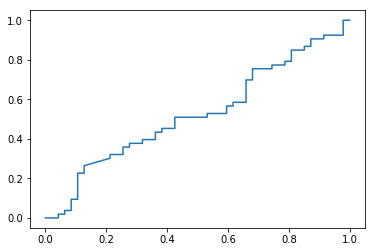

In [70]:
fpr, tpr, thresholds = metrics.roc_curve(la, pre, pos_label=1)
print(metrics.auc(fpr, tpr))
plt.plot(fpr,tpr)

D:\installation\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


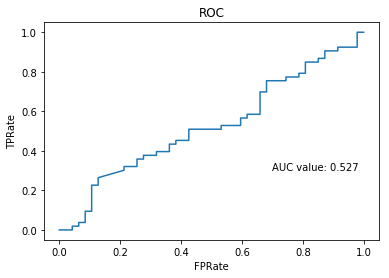

0.5274989963869932 0.5258932155760738


In [71]:
ROC(la,pre,pos_label=1,method=1)